# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr).

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import pylab as pl
import mpl_toolkits.axisartist
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import string

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, _extract_interface

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/opt/mandyoc-scripts/sty/mandyoc.mplstyle')

In [5]:
def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def _log_fmt(x, pos):
    return "{:.0f}".format(np.log10(x))

def plot_instants(ax, datasets, dataset, prop, instant, instants, letter=''):
    
    label_size=20
    plt.rc('xtick', labelsize = label_size)
    plt.rc('ytick', labelsize = label_size)
    
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'radiogenic_heat':      'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':             'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':           'Topography [km]',
                   'viscosity':            'log(Pa.s)',
                   'vs_anomaly':           r'dVs/Vs [\%]'
                   }
    
    props_cmap = {'density': 'viridis',
                  'radiogenic_heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
                  'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'Greys',
#                   'strain': 'inferno',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }
    
#     vals_minmax = {'density':             [0.0, float(datasets.density.max())],
#                    'heat':                [float(datasets.radiogenic_heat.min()), float(datasets.radiogenic_heat.max())],
#                    'lithology':           [None, None],
#                    'pressure':            [float(datasets.pressure.min())/1.0e9, float(datasets.pressure.max())/1.0e9],
#                    'strain':              [None, None],
#                    'strain_rate':         [float(datasets.strain_rate.min()), float(datasets.strain_rate.max())],
#                    'temperature':         [0, float(datasets.temperature.max())],
#                    'temperature_anomaly': [-150, 150],
#                    'surface':             [float(datasets.surface.min())/1.0e3 + 40, float(datasets.surface.max())/1.0e3 + 40],
#                    'viscosity':           [float(datasets.viscosity.min()), float(datasets.viscosity.max())]
#                   }

#     vals_minmax = {'density':             [0.0, 3378.],
#                    'radiogenic_heat':     [1.0E-13, 1.0E-9],
#                    'lithology':           [None, None],
#                    'pressure':            [-1.0E-3, 1.0],
#                    'strain':              [None, None],
#                    'strain_rate':         [1.0E-19, 1.0E-14],
# #                    'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-14)],
#                    'temperature':         [0, 1600],
#                    'temperature_anomaly': [-150, 150],
#                    'surface':             [-6, 6],
#                    'viscosity':           [1.0E18, 1.0E25],
# #                    'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
#                   }

    Nx = int(dataset.nx)
    Nz = int(dataset.nz)
    Lx = float(dataset.lx)
    Lz = float(dataset.lz)
    
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)
    
    air_thickness = 40.0 #km
    
    if (prop != 'surface'):
        xlims = [0, float(dataset.x.max()) / 1.0e3]
        ylims = [-Lz / 1.0e3 + air_thickness, 0 + air_thickness]
    else:
        xlims = [0, float(dataset.x.max()) / 1.0e3]
        ylims = [np.floor(float(dataset[prop].min()) / 1.0e3 + air_thickness), np.ceil(float(dataset[prop].max()) / 1.0e3 + air_thickness)]
        
        
#     val_minmax = vals_minmax[prop]
    
    
    #Dealing with data
    if(prop == 'lithology'):
        data = dataset['strain']
        vals_minmax = [None, None]
        
    elif(prop == 'temperature_anomaly'):
        #removing horizontal mean temperature
        A = dataset['temperature']
        B = A.T #shape: (Nz, Nx)
        C = np.mean(B, axis=1) #shape: 151==Nz
        D = (B.T - C) #B.T (Nx,Nz) para conseguir subtrair C
        data = D
        val_minmax = [-150, 150]
        
    elif(prop == 'surface'):
#         topo_from_density = True
        topo_from_density = False
        
        if(topo_from_density == True):
            Rhoi = dataset.density.T
            interfaces=[2900, 3365]
            ##Extract layer topography
            z = np.linspace(Lz/1000.0, 0, Nz)
            Z = np.linspace(Lz/1000.0, 0, 8001) #zi
            x = np.linspace(Lx/1000.0, 0, Nx)

            topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
            
            condx = (xi >= 100) & (xi <= 600)
            z_mean = np.mean(topo_interface[condx])
            
            topo_interface -= np.abs(z_mean)
            topo_interface = -1.0*topo_interface

            data = topo_interface
        else:
            data = dataset.surface/1.0e3 + 40.0 #km + air layer correction
            
        val_minmax = [datasets[prop].min()/1.0e3 + air_thickness, datasets[prop].max()/1.0e3 + air_thickness]
            
    elif(prop == 'pressure'):
        data = dataset[prop]/1.0E9 #GPa
        val_minmax = [datasets[prop].min()/1.0E9, datasets[prop].max()/1.0E9]
        
    elif(prop == 'viscosity' or prop == 'radiogenic_heat' or prop == 'strain_rate'):
        data = dataset[prop]
        data_new = data.where(data > 0, np.maximum(data, 1.0e-28))
        data = np.log10(data_new)
        
        datasets_aux = datasets[prop]
        datasets_aux = datasets.where(datasets > 0, np.maximum(datasets, 1.0e-28))
        datasets_aux = np.log10(datasets_aux)
        val_minmax = [np.log10(1.0E18), np.log10(1.0E25)]
#         val_minmax = [datasets_aux[prop].min(), datasets_aux[prop].max()]
        
    elif(prop == 'strain'):
        data = dataset[prop]
        val_minmax = [None, None]
        
    else:
        data = dataset[prop]
        val_minmax = [datasets[prop].min(), datasets[prop].max()]
        
    #Plot data
    if(prop != 'topography'): #Plot isotherms
        Temperi = dataset.temperature.T
        
        isotherms=[550, 800, 1300]
        isot_colors = []
        for isotherm in isotherms:
            isot_colors.append('red')
            
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=isot_colors)
        
        if(instant == instants[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
#     if(prop == 'strain_rate'): #properties that need a lognorm colorbar
#         im = ax.imshow(data.T,
#                        cmap = props_cmap[prop],
#                        origin='lower',
#                        extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
#                        norm = LogNorm(vmin=val_minmax[0], vmax=val_minmax[1]),
# #                        vmin=val_minmax[0], vmax=val_minmax[1],
#                        aspect = 'auto')
        
#         #creating colorbar
#         if(instant == instants[-1]):
#             axins1 = inset_axes(ax,
#                                 width="30%",  # width: 30% of parent_bbox width
#                                 height="5%",  # height: 5%
#                                 bbox_to_anchor=(-0.02, -0.58, 1, 1),
#                                 bbox_transform=ax.transAxes,
#                                 )
# #             ticks = np.linspace(0.01*val_minmax[1], val_minmax[1], 5, endpoint=True, dtype=int)
#             clb = fig.colorbar(im,
#                                cax=axins1,
# #                                ticks=ticks,
#                                orientation='horizontal',
#                                fraction=0.08,
#                                pad=0.2,
#                                format=_log_fmt)

#             clb.set_label(props_label[prop], fontsize=12)
#             clb.minorticks_off()
    
#     el
    if (prop == 'density' or prop == 'pressure' or prop == 'radiogenic_heat' or prop == 'strain_rate' or prop == 'temperature' or prop == 'temperature_anomaly' or prop == 'viscosity'): #properties that need a regular colorbar
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin=val_minmax[0], vmax=val_minmax[1],
                       aspect = 'auto')
        
        if(instant == instants[-1]):
            axins1 = inset_axes(ax,
                                width="30%",  # width: 30% of parent_bbox width
                                height="5%",  # height: 5%
                                bbox_to_anchor=(-0.02, -0.58, 1, 1),
                                bbox_transform=ax.transAxes,
                                )

    #         ticks = np.linspace(val_minmax[0], val_minmax[1], 6, endpoint=True)

            #precision of colorbar ticks
            if(prop == 'pressure'): 
                fmt = '%.2f'
            else:
                fmt = '%.0f'
            
            ticks = np.linspace(np.round(val_minmax[0], 0), np.round(val_minmax[1], 0), 5, endpoint=True, dtype=int)
            clb = fig.colorbar(im,
                               cax=axins1,
                               ticks=ticks,
                               orientation='horizontal',
                               fraction=0.08,
                               pad=0.2,
                               format=fmt)

            clb.set_label(props_label[prop], fontsize=12)
            clb.minorticks_off()
        
    elif (prop == 'strain'):
        im = ax.imshow(data.T,
                       cmap = props_cmap[prop],
                       origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = float(data.min()),
                       vmax = float(data.max()),
                       aspect = 'auto')
        
        axins1 = inset_axes(ax,
                            width="30%",  # width: 30% of parent_bbox width
                            height="5%",  # height: 5%
                            bbox_to_anchor=(-0.02, -0.58, 1, 1),
                            bbox_transform=ax.transAxes,
                            )

            
#         ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True, dtype=int)
        ticks = np.arange(float(data.min()), float(data.max()), 5)
        fmt = '%.0f'
        clb = fig.colorbar(im,
                           cax=axins1,
#                            ax=ax,
                           ticks=ticks,
                           orientation='horizontal',
                           fraction=0.08,
                           pad=0.2,
                           format=fmt)

        clb.set_label(props_label[prop], fontsize=12)
        clb.minorticks_off()
        clb.set_label(props_label[prop], fontsize=12)
        
    elif(prop == 'surface'):
        ax.plot(dataset.x/1.0e3, data, alpha = 1, linewidth = 2.0, color = "blueviolet")
        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_uc = (228. / cr, 156. / cr, 124. / cr)
        color_lc = (240. / cr, 209. / cr, 188. / cr)
        color_lit = (155. / cr, 194. / cr, 155. / cr)
        color_ast = (207. / cr, 226. / cr, 205. / cr)
        
        Rhoi = dataset.density.T
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx,
                    zz,
                    Rhoi,
                    levels = [200., 2750, 2900, 3365, 3900],
                    colors = [color_uc, color_lc, color_lit, color_ast])
        
        im=ax.imshow(data.T,
                     cmap = 'Greys',
                     origin = 'lower',
                     extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
#                      extent = (300, 1100, -300, 40),
                     zorder = 50,
                     alpha = 0.2, vmin=-0.5,
                     vmax = 0.7,
                     aspect = 'auto')
        #legend box
        if(instant == instants[-1]):
            if (len(instants) > 1):
                b1 = [0.89, #horizontal position
                      0.14, #vertical position
                      0.08, #horizontal sift
                      0.08  #scale
                     ]
            else:
                b1 = [0.84, #horizontal position
                      0.4, #vertical position
                      0.15, #horizontal sift
                      0.20  #scale
                     ]
                    
            bv1 = plt.axes(b1)
            A = np.zeros((100, 10))

            A[:25, :] = 2700
            A[25:50, :] = 2800
            A[50:75, :] = 3300
            A[75:100, :] = 3400

            A = A[::-1, :]

            xA = np.linspace(-0.5, 0.9, 10)
            yA = np.linspace(0, 1.5, 100)

            xxA, yyA = np.meshgrid(xA, yA)
            air_threshold = 200
            plt.contourf(
                xxA,
                yyA,
                A,
                levels=[air_threshold, 2750, 2900, 3365, 3900],
                colors=[color_uc, color_lc, color_lit, color_ast],
            )

            plt.imshow(
                xxA[::-1, :],
                extent=[-0.5, 0.9, 0, 1.5],
                zorder=100,
                alpha=0.2,
                cmap=plt.get_cmap("Greys"),
                vmin=-0.5,
                vmax=0.9,
            )

            bv1.set_yticklabels([])
            plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
            bv1.tick_params(axis='x', which='major', labelsize=12)
            bv1.set_xticks([-0.5, 0, 0.5])
            bv1.set_yticks([])
            bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            
    if(prop != 'surface'):
        #Filling above topographic surface
        Rhoi = dataset.density.T
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)

        topo_interface = _extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface

        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

        ax.fill_between(xaux, topo_interface[condaux], 39, color='white', alpha=1.0, zorder=51)
        
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
#         ax.set_xlim([300, 1100])
#         ax.set_ylim([-300+40, 40])
#         ax.set_yticks([-200, -100, 0])
        if(instant == instants[-1]):
            ax.set_xlabel("Distance (km)", fontsize = label_size)
        ax.set_ylabel("Depth (km)", fontsize = label_size)
        
        
        if(len(instants)>1):
            label_text = f"{letter}){str(instant)} Myr"
        else:
            label_text = f"{letter}{str(instant)} Myr"
        fsize = 20
        ax.text(0.015,
                0.90,
                label_text,
                color='k',
                bbox=dict(edgecolor = 'white',
                          facecolor = 'white',
                          alpha = 0.6),
                fontsize=fsize,
                horizontalalignment='left',
                verticalalignment='center',
                transform=ax.transAxes,
                zorder=52)
        
    else:
        ax.grid('-k', alpha=0.7)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        
        yticks = np.arange(ylims[0], ylims[1], 1)
        ax.set_yticks(yticks)
        if(instant == instants[-1]):
            ax.set_xlabel("Distance (km)", fontsize = label_size)
            
        ax.set_ylabel("Topography (km)", fontsize = label_size)

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property that you want to visualize uncommenting one of the commented options of `output`.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

ACC_Clc10_DT290_PT1421oC_lit150km_4x4km2_lithology


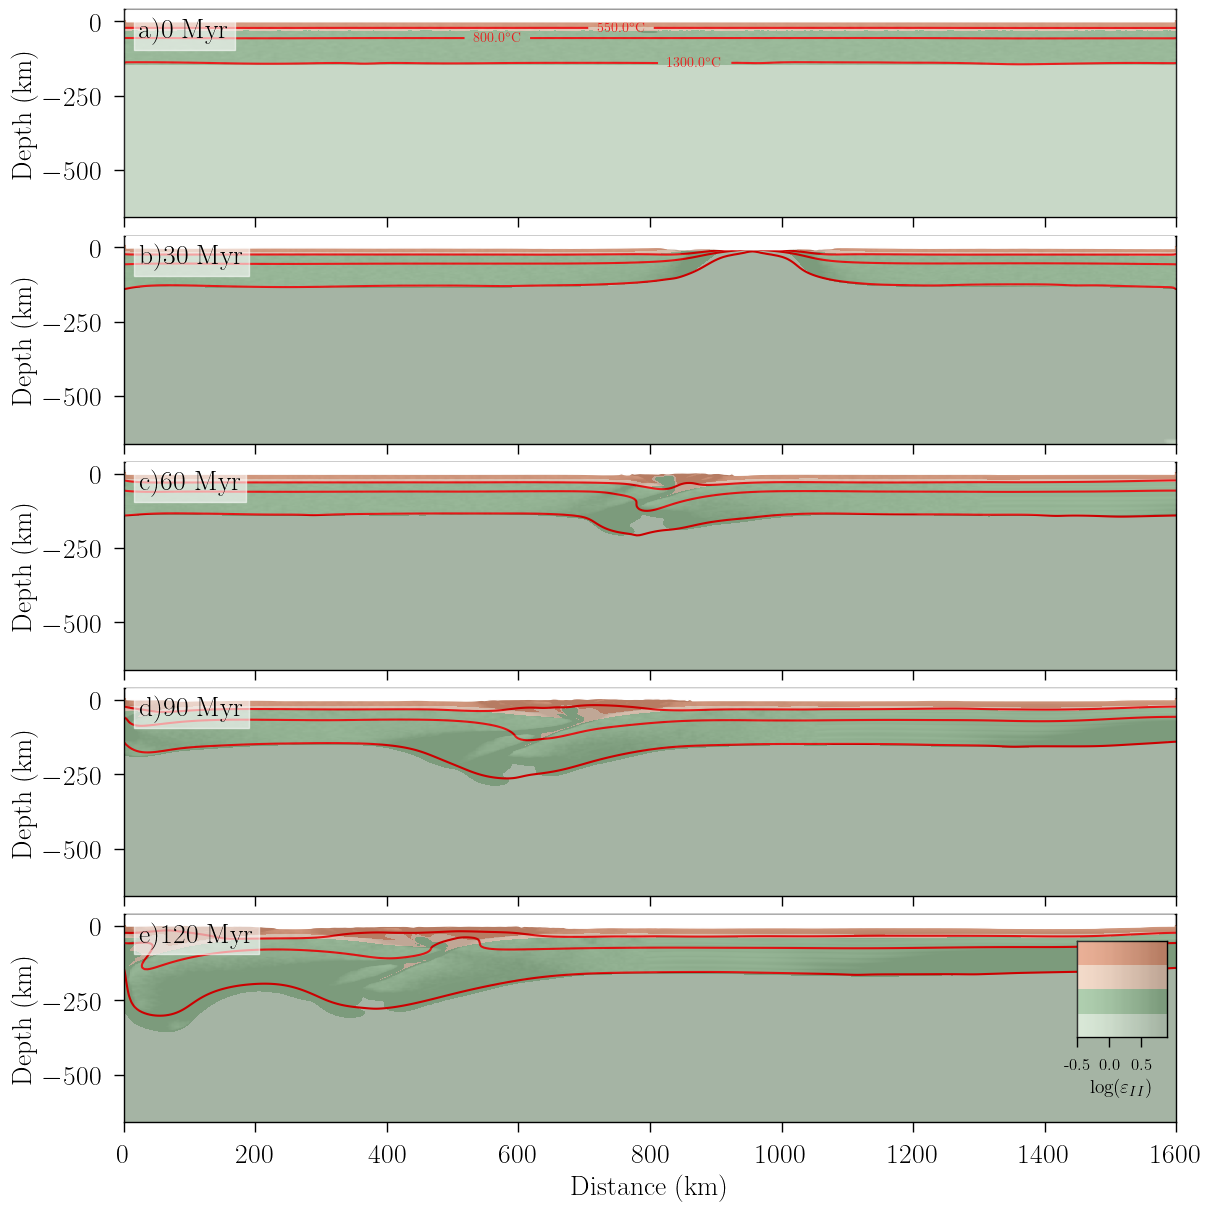

In [13]:
output = [#Properties from mandyoc. Comment/uncomment to select witch one you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
#              'strain_rate',
#              'temperature',
#              'temperature_anomaly',
#              'surface',
#              'viscosity'
             ]
prop = output[0]
################################################################################################################################

#Set scenario path

#RFT
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK'

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK'

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK'

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK'

#ACC
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT200_PT1291oC/ACC_Clc1_DT200_PT1291oC_lit80km_4x4km2' #lit80km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT200_PT1291oC/ACC_Clc10_DT200_PT1291oC_lit80km_4x4km2' #lit80km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT290_PT1349oC/ACC_Clc1_DT290_PT1349oC_lit80km_4x4km2' #lit80km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT290_PT1349oC/ACC_Clc10_DT290_PT1349oC_lit80km_4x4km2' #lit80km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT350_PT1397oC/ACC_Clc1_DT_350_PT1397_lit80km_4x4km2' #lit80km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT350_PT1397oC/ACC_Clc10_DT_350_PT1397_lit80km_4x4km2' #lit80km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT350_PT1397oC/ACC_Clc1_DT_350_PT1397_lit80km_4x4km2' #lit80km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit80km/DT350_PT1397oC/ACC_Clc10_DT_350_PT1397_lit80km_4x4km2' #lit80km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit150km/DT290_PT1421oC/ACC_Clc1_DT290_PT1421oC_lit150km_4x4km2'
scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit150km/DT290_PT1421oC/ACC_Clc10_DT290_PT1421oC_lit150km_4x4km2'


#ACC - WITH MEAN TEMPERATURE IN LITHOSPHERE
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT350_PT1397oC/ACC_Clc1_DT350_PT1397_lit80km_4x4km2_mtl' #lit80km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT350_PT1397oC/ACC_Clc10_DT350_PT1397_lit80km_4x4km2_mtl' #lit80km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT400_PT1437oC/ACC_Clc1_DT400_PT1437oC_lit80km_4x4km2_mtl' #lit80km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT400_PT1437oC/ACC_Clc10_DT400_PT1437oC_lit80km_4x4km2_mtl' #lit80km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/ACC_Clc1_DT200_PT1352oC_lit150km_4x4km2_mtl' #lit150km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/ACC_Clc10_DT200_PT1352oC_lit150km_4x4km2_mtl' #lit150km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1421oC/ACC_Clc1_DT290_PT1421oC_lit150km_4x4km2_mtl' #lit150km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1421oC/ACC_Clc10_DT290_PT1421oC_lit150km_4x4km2_mtl' #lit150km

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/ACC_Clc1_DT350_PT1460oC_lit150km_4x4km2_mtl' #lit150km
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/ACC_Clc10_DT350_PT1460oC_lit150km_4x4km2_mtl' #lit150km

model_path = machine_path + scenario

#Read datasets
datasets = xr.open_dataset(f"{model_path}/data.nc")

#Set instants

instants = [0, 30, 60, 90, 120]
# instants = [5, 10, 20, 30, 40]
# instants = [0.1, 0.2, 0.3]
################################################################################################################################

#Creating canvas
plt.close()

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 3) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12, fig_height), sharex=True, sharey=True)
    axs = axs.flatten()
else:
    fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12,4), sharex=True, sharey=True)


alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

if(len(instants) > 1):
    for instant, letter, ax in zip(instants, letters, axs):
        idx = find_nearest(datasets.time, instant)
        dataset = datasets.isel(time=idx)
        plot_instants(ax, datasets, dataset, prop, instant, instants, letter)
else:
    instant = instants[0]
    idx = find_nearest(datasets.time, instant)
    dataset = datasets.isel(time=idx)
    plot_instants(axs, datasets, dataset, prop, instant, instants)

################################################################################################################################

# #Saving figure
savefig = True
# savefig = False

if(savefig == True):
    figname = f"{scenario.split('/')[-1]}_{prop}"
    print(figname)

    # #This will save inside the notebook directory
    fig.savefig(f"out/{figname}.pdf", dpi=400)
    fig.savefig(f"out/{figname}.png", dpi=400)

    # #This will save inside the experiment directory
    fig.savefig(f"{model_path}/{figname}.pdf", dpi=400)
    fig.savefig(f"{model_path}/{figname}.png", dpi=400)

In [ ]:
datasets.time